<a href="https://colab.research.google.com/github/Arvind-55555/CO2-equivalent-emissions-LCA-in-textiles-Industry/blob/main/CO2_equivalent_emissions(LCA)_in_textiles_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** The model predicts a single impact category CO2 emissions for a specific textile product based on input parameters.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

**Data Set Input Features and Target Variable**

* **Input Features (X):**

    * **Material Type:** (e.g., Cotton, Polyester, Linen, Viscose).

    * **Material Source:** (e.g., Conventional, Organic, Recycled).

    * **Manufacturing Processes:**

      * Spinning method (e.g., ring-spun, open-end)

      * Weaving/Knitting type

      * Dyeing methods (e.g., conventional, natural)

      * Finishing methods (e.g., chemical treatments)

      * Energy source for production (e.g., renewable, fossil fuels)

    * **Transportation:** Distance and mode of transport at various stages.

    * **Production Volume:** Quantity of textiles produced.

    * **Location:** Geographic location of production, influencing energy mix and transport.

    * **Recycled Content:** Percentage of recycled materials used.

    * **Process Data:** Detailed inputs/outputs of specific processes (water consumption, chemical usage, energy)

* **Target Variable (y):** CO2 emissions (kg CO2e) per unit of textile product  per kg of fabric or per garment.

In [2]:
# Set a seed for reproducibility
np.random.seed(42)

# --- Define Data Ranges ---
num_samples = 500

materials = ['Cotton', 'Polyester', 'Linen', 'Viscose', 'Recycled Cotton', 'Recycled Polyester']
sources = ['Conventional', 'Organic', 'Recycled']
spinning_methods = ['Ring-Spun', 'Open-End', 'Air-Jet']
weaving_methods = ['Woven', 'Knitted']
dyeing_methods = ['Conventional', 'Natural', 'Solution Dyeing']
finishing_methods = ['Chemical', 'Mechanical', 'None']
energy_sources = ['Fossil Fuels', 'Renewable', 'Mixed']
transport_modes = ['Road', 'Sea', 'Air']

In [3]:
# Create Data
data = {
    'Material': np.random.choice(materials, num_samples),
    'Source': np.random.choice(sources, num_samples),
    'Spinning': np.random.choice(spinning_methods, num_samples),
    'Weaving': np.random.choice(weaving_methods, num_samples),
    'Dyeing': np.random.choice(dyeing_methods, num_samples),
    'Finishing': np.random.choice(finishing_methods, num_samples),
    'Energy': np.random.choice(energy_sources, num_samples),
    'Transport_Distance': np.random.uniform(100, 5000, num_samples), #km
    'Transport_Mode': np.random.choice(transport_modes, num_samples),
     'Production_Volume': np.random.uniform(1000, 100000, num_samples), # in kg
     'Recycled_Content': np.random.uniform(0, 1, num_samples),  # Percentage (0-1)
    }

df = pd.DataFrame(data)

In [4]:
df.head(10)

,Material,Source,Spinning,Weaving,Dyeing,Finishing,Energy,Transport_Distance,Transport_Mode,Production_Volume,Recycled_Content
0,Viscose,Conventional,Open-End,Woven,Natural,Chemical,Fossil Fuels,3502.807235,Road,37981.925304,0.123233
1,Recycled Cotton,Organic,Open-End,Woven,Conventional,None,Renewable,502.814612,Air,5998.405497,0.698531
2,Linen,Organic,Air-Jet,Woven,Conventional,Mechanical,Mixed,4562.315239,Air,63121.170607,0.416145
3,Recycled Cotton,Conventional,Open-End,Knitted,Conventional,Chemical,Fossil Fuels,2375.722858,Road,39175.737774,0.513851
4,Recycled Cotton,Recycled,Air-Jet,Woven,Conventional,None,Renewable,773.866497,Sea,93690.446802,0.903298
5,Polyester,Organic,Open-End,Knitted,Solution Dyeing,Chemical,Renewable,1769.996929,Sea,54657.017414,0.889884
6,Linen,Organic,Open-End,Knitted,Solution Dyeing,Chemical,Mixed,907.640909,Sea,94025.499618,0.817856
7,Linen,Organic,Open-End,Woven,Natural,Mechanical,Renewable,935.851367,Road,22827.885654,0.510148
8,Linen,Conventional,Air-Jet,Knitted,Natural,Chemical,Fossil Fuels,4745.730769,Sea,72846.865126,0.736240
9,Recycled Cotton,Organic,Air-Jet,Knitted,Solution Dyeing,None,Renewable,2281.705950,Road,62107.653064,0.512897


In [5]:
# --- Create a Synthetic CO2 emission (Target) ---

# Define some base emission values
material_emission = {'Cotton': 10, 'Polyester': 25, 'Linen': 12, 'Viscose': 18,
                    'Recycled Cotton': 5, 'Recycled Polyester': 15}
source_emission = {'Conventional': 1, 'Organic': 0.5, 'Recycled': 0.2}
spinning_emission = {'Ring-Spun': 2, 'Open-End': 1.5, 'Air-Jet': 1.8}
weaving_emission = {'Woven': 1, 'Knitted': 0.8}
dyeing_emission = {'Conventional': 3, 'Natural': 0.8, 'Solution Dyeing': 1.2}
finishing_emission = {'Chemical': 2, 'Mechanical': 1, 'None': 0.2}
energy_emission = {'Fossil Fuels': 5, 'Renewable': 1, 'Mixed': 3}
transport_emission_factor = {'Road': 0.01, 'Sea': 0.005, 'Air': 0.05}  # gCO2e/km

In [6]:
df['CO2_emissions'] = 0

for index,row in df.iterrows():
    emissions= (
        material_emission[row['Material']]
        + source_emission[row['Source']]
        + spinning_emission[row['Spinning']]
        + weaving_emission[row['Weaving']]
        + dyeing_emission[row['Dyeing']]
        + finishing_emission[row['Finishing']]
        + energy_emission[row['Energy']]
        + row['Transport_Distance'] * transport_emission_factor[row['Transport_Mode']]
    )

    emissions = emissions * (1-row['Recycled_Content'])

    emissions = emissions * row['Production_Volume']/1000 # scaling emissions by production volume and bringing it to Kg instead of ton

    df.loc[index, 'CO2_emissions'] = emissions


print(df.head(10))

          Material        Source  Spinning  Weaving        Dyeing   Finishing  \
0          Viscose  Conventional  Open-End    Woven       Natural    Chemical   
1  Recycled Cotton       Organic  Open-End    Woven  Conventional        None   
2            Linen       Organic   Air-Jet    Woven  Conventional  Mechanical   
3  Recycled Cotton  Conventional  Open-End  Knitted  Conventional    Chemical   
4  Recycled Cotton      Recycled   Air-Jet    Woven  Conventional        None   

         Energy  Transport_Distance Transport_Mode  Production_Volume  \
0  Fossil Fuels         3502.807235           Road       37981.925304   
1     Renewable          502.814612            Air        5998.405497   
2         Mixed         4562.315239            Air       63121.170607   
3  Fossil Fuels         2375.722858           Road       39175.737774   
4     Renewable          773.866497            Sea       93690.446802   

   Recycled_Content  CO2_emissions  
0          0.123233    2142.209389  


<ipython-input-6-7e8c542a82fb>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2142.20938896806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'CO2_emissions'] = emissions


In [7]:
df.head(10)

,Material,Source,Spinning,Weaving,Dyeing,Finishing,Energy,Transport_Distance,Transport_Mode,Production_Volume,Recycled_Content,CO2_emissions
0,Viscose,Conventional,Open-End,Woven,Natural,Chemical,Fossil Fuels,3502.807235,Road,37981.925304,0.123233,2142.209389
1,Recycled Cotton,Organic,Open-End,Woven,Conventional,None,Renewable,502.814612,Air,5998.405497,0.698531,67.524571
2,Linen,Organic,Air-Jet,Woven,Conventional,Mechanical,Mixed,4562.315239,Air,63121.170607,0.416145,9228.719285
3,Recycled Cotton,Conventional,Open-End,Knitted,Conventional,Chemical,Fossil Fuels,2375.722858,Road,39175.737774,0.513851,800.990691
4,Recycled Cotton,Recycled,Air-Jet,Woven,Conventional,None,Renewable,773.866497,Sea,93690.446802,0.903298,145.588992
5,Polyester,Organic,Open-End,Knitted,Solution Dyeing,Chemical,Renewable,1769.996929,Sea,54657.017414,0.889884,245.860824
6,Linen,Organic,Open-End,Knitted,Solution Dyeing,Chemical,Mixed,907.640909,Sea,94025.499618,0.817856,437.371169
7,Linen,Organic,Open-End,Woven,Natural,Mechanical,Renewable,935.851367,Road,22827.885654,0.510148,303.694016
8,Linen,Conventional,Air-Jet,Knitted,Natural,Chemical,Fossil Fuels,4745.730769,Sea,72846.865126,0.736240,905.534808
9,Recycled Cotton,Organic,Air-Jet,Knitted,Solution Dyeing,None,Renewable,2281.705950,Road,62107.653064,0.512897,1007.935027


# Data Exploration

In [23]:
print("\n--- Data Information ---")
print(df.info())


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Material            500 non-null    object 
 1   Source              500 non-null    object 
 2   Spinning            500 non-null    object 
 3   Weaving             500 non-null    object 
 4   Dyeing              500 non-null    object 
 5   Finishing           500 non-null    object 
 6   Energy              500 non-null    object 
 7   Transport_Distance  500 non-null    float64
 8   Transport_Mode      500 non-null    object 
 9   Production_Volume   500 non-null    float64
 10  Recycled_Content    500 non-null    float64
 11  CO2_emissions       500 non-null    float64
dtypes: float64(4), object(8)
memory usage: 47.0+ KB
None


In [24]:
print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df.describe())


--- Descriptive Statistics (Numerical Features) ---
       Transport_Distance  Production_Volume  Recycled_Content  CO2_emissions
count          500.000000         500.000000        500.000000     500.000000
mean          2611.761284       52465.870695          0.485431    2402.120565
std           1414.088721       27859.258596          0.287271    3504.240403
min            110.308832        1310.949699          0.001346       0.124593
25%           1399.945108       31088.940198          0.238643     397.669881
50%           2707.217082       53048.485753          0.480040    1072.325483
75%           3803.437996       76247.588726          0.742497    2661.967212
max           4998.597640       99629.966366          0.997623   20571.387050


In [26]:
print("\n--- Value Counts (Categorical Features) ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}:\n{df[col].value_counts()}")


--- Value Counts (Categorical Features) ---

Material:
Material
Viscose               97
Cotton                90
Recycled Polyester    86
Linen                 77
Recycled Cotton       75
Polyester             75
Name: count, dtype: int64

Source:
Source
Conventional    189
Organic         159
Recycled        152
Name: count, dtype: int64

Spinning:
Spinning
Open-End     168
Air-Jet      168
Ring-Spun    164
Name: count, dtype: int64

Weaving:
Weaving
Woven      264
Knitted    236
Name: count, dtype: int64

Dyeing:
Dyeing
Natural            179
Conventional       169
Solution Dyeing    152
Name: count, dtype: int64

Finishing:
Finishing
Chemical      174
Mechanical    174
None          152
Name: count, dtype: int64

Energy:
Energy
Renewable       169
Fossil Fuels    168
Mixed           163
Name: count, dtype: int64

Transport_Mode:
Transport_Mode
Road    172
Air     165
Sea     163
Name: count, dtype: int64


In [27]:
print("\n--- Checking for missing values ---")
print(df.isnull().sum())


--- Checking for missing values ---
Material              0
Source                0
Spinning              0
Weaving               0
Dyeing                0
Finishing             0
Energy                0
Transport_Distance    0
Transport_Mode        0
Production_Volume     0
Recycled_Content      0
CO2_emissions         0
dtype: int64


# Distribution Analysis

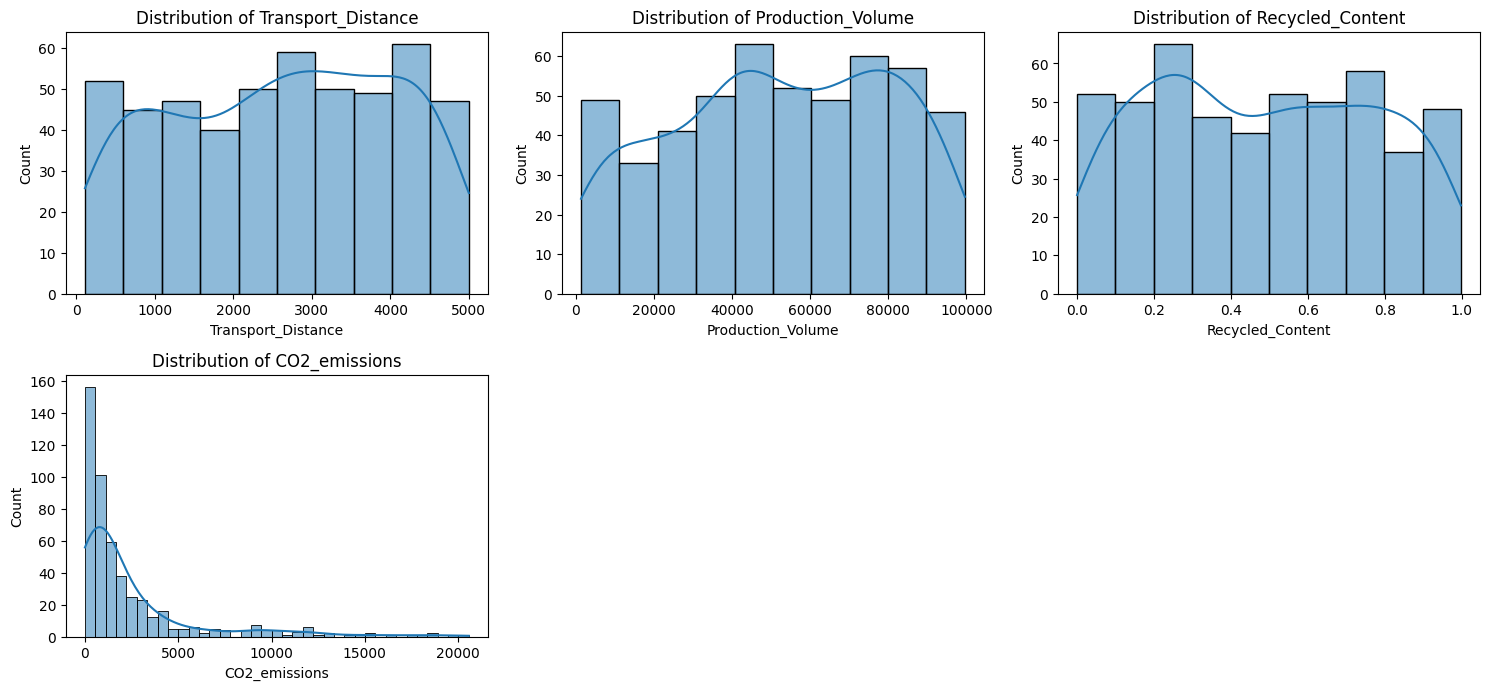

In [29]:
# --- Distribution Analysis (Numerical Features) ---
import seaborn as sns
numerical_features = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

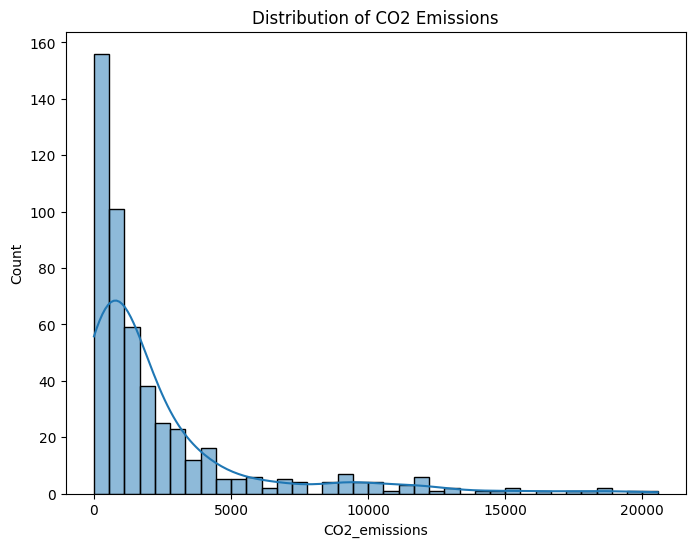

In [30]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['CO2_emissions'], kde=True)
plt.title("Distribution of CO2 Emissions")
plt.show()

# Correlation Analysis

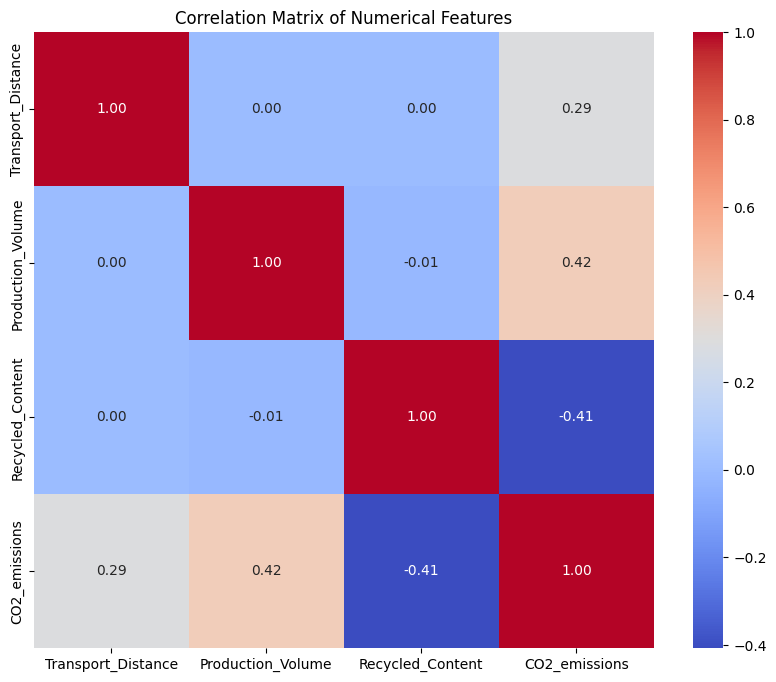

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Relationship between Categorical and Numerical variables

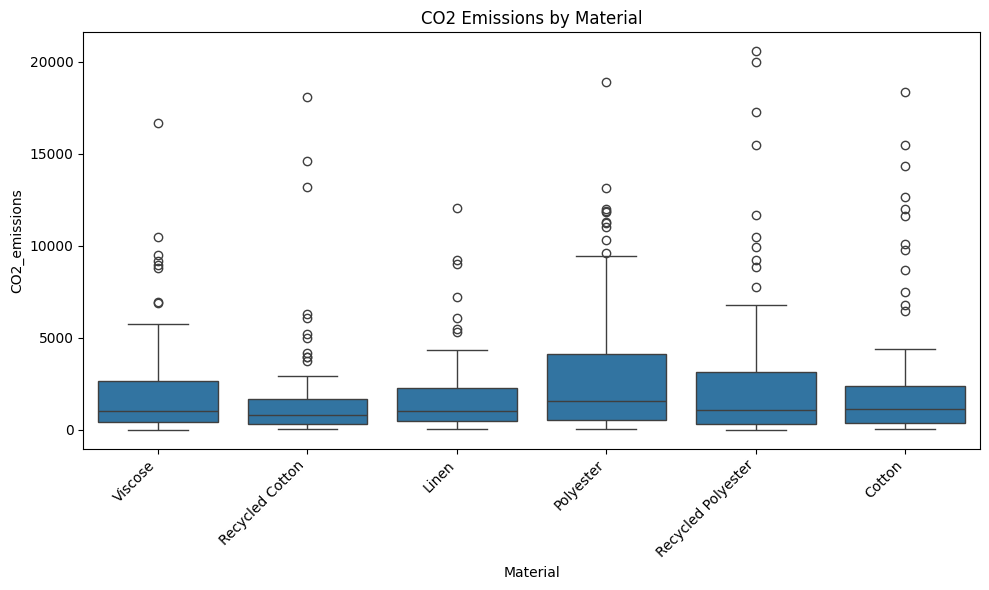

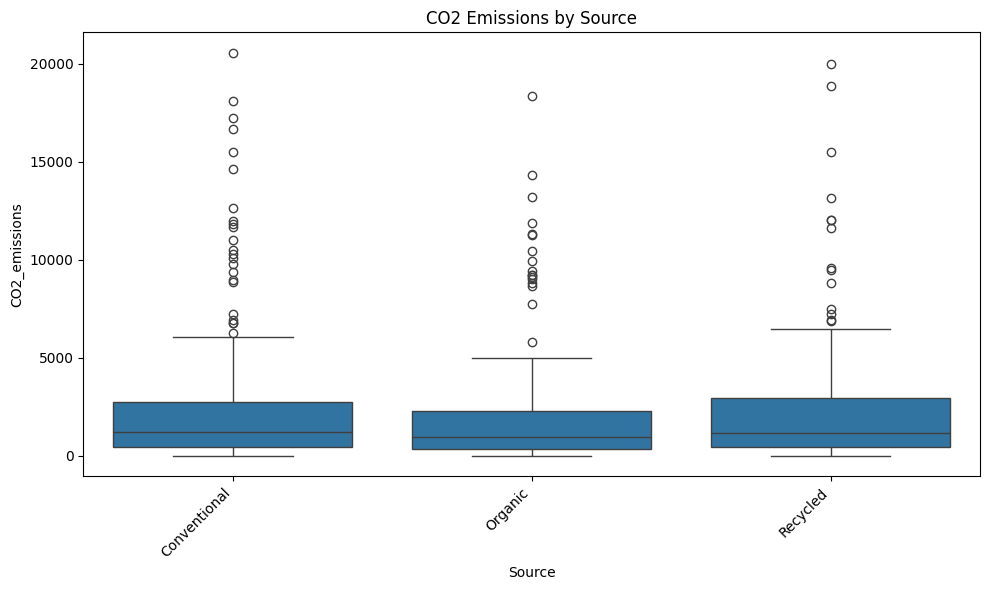

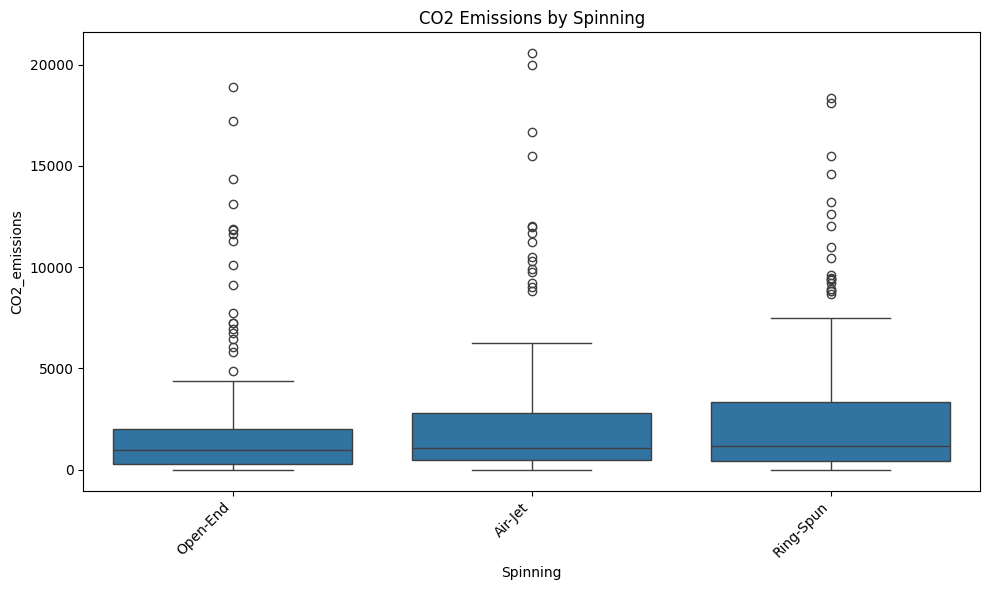

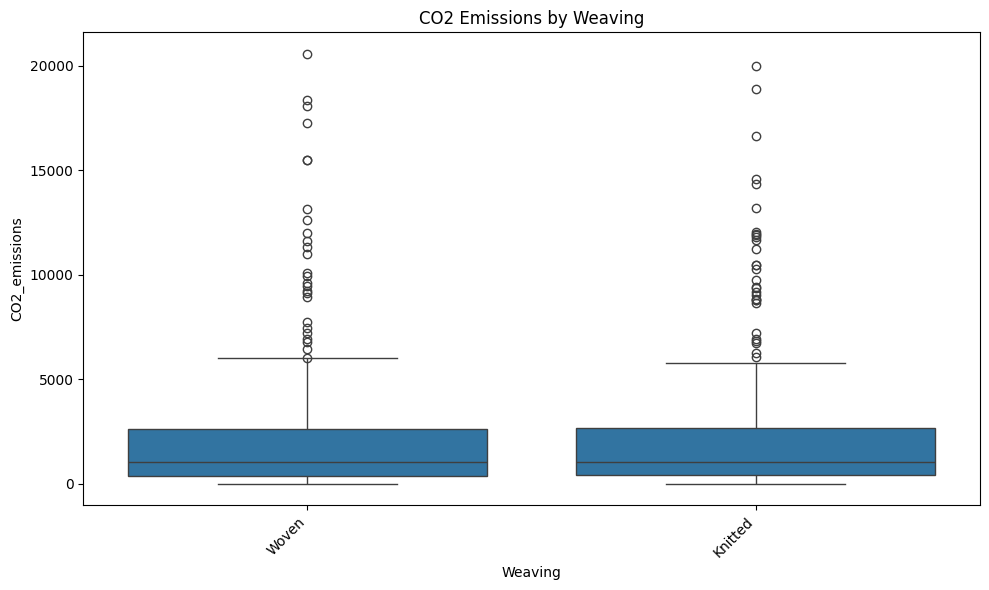

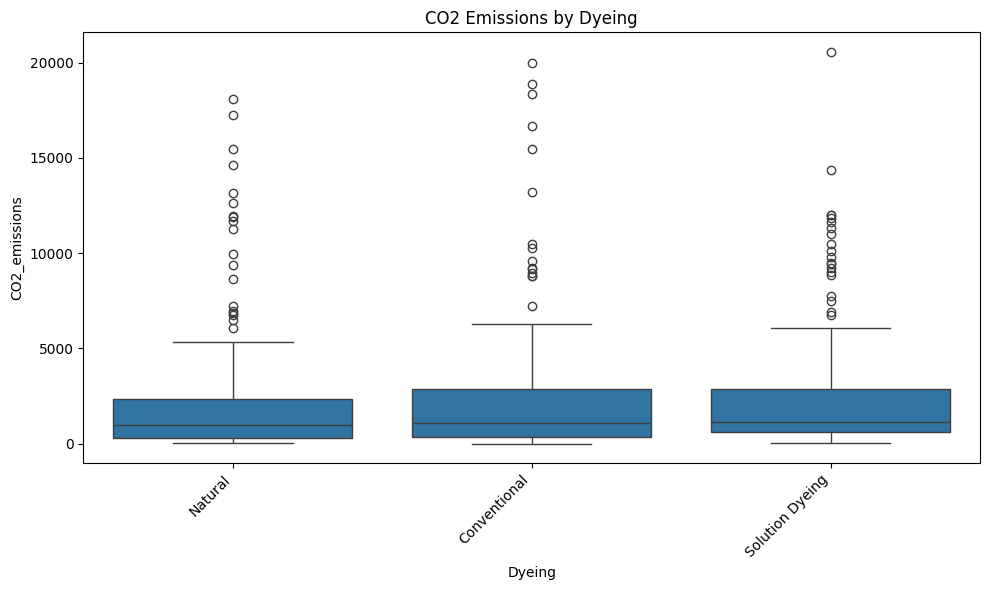

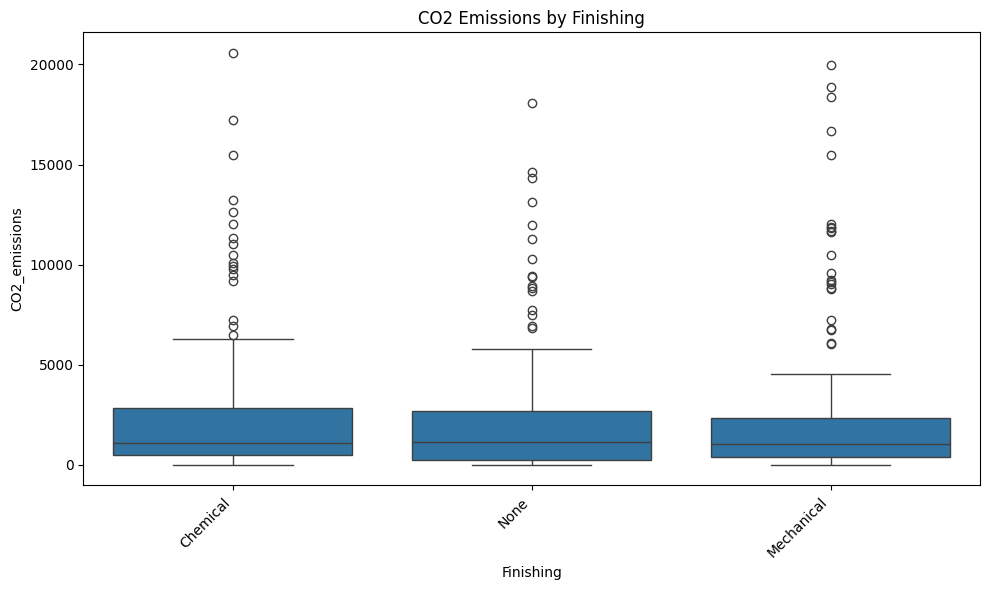

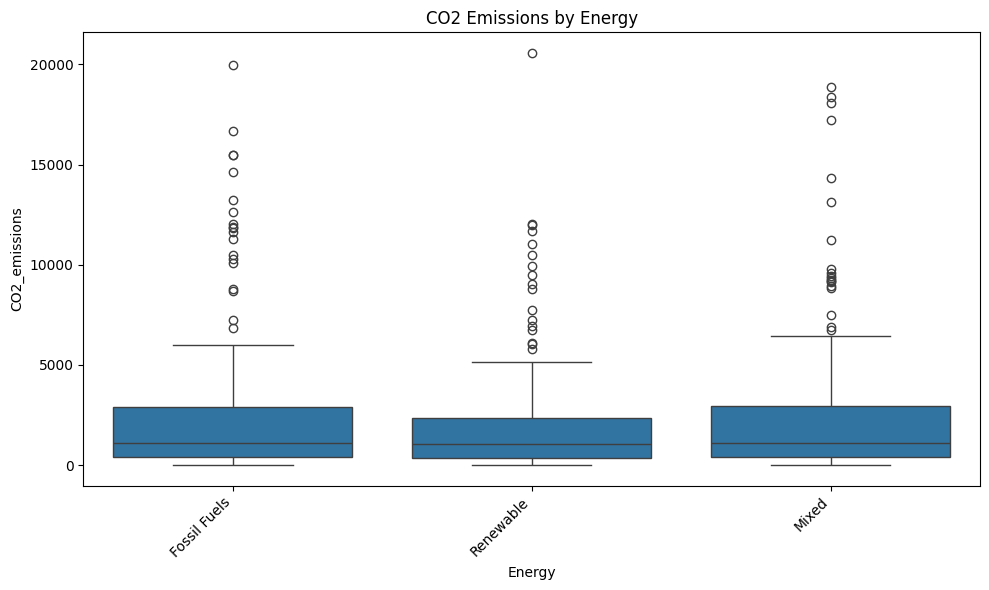

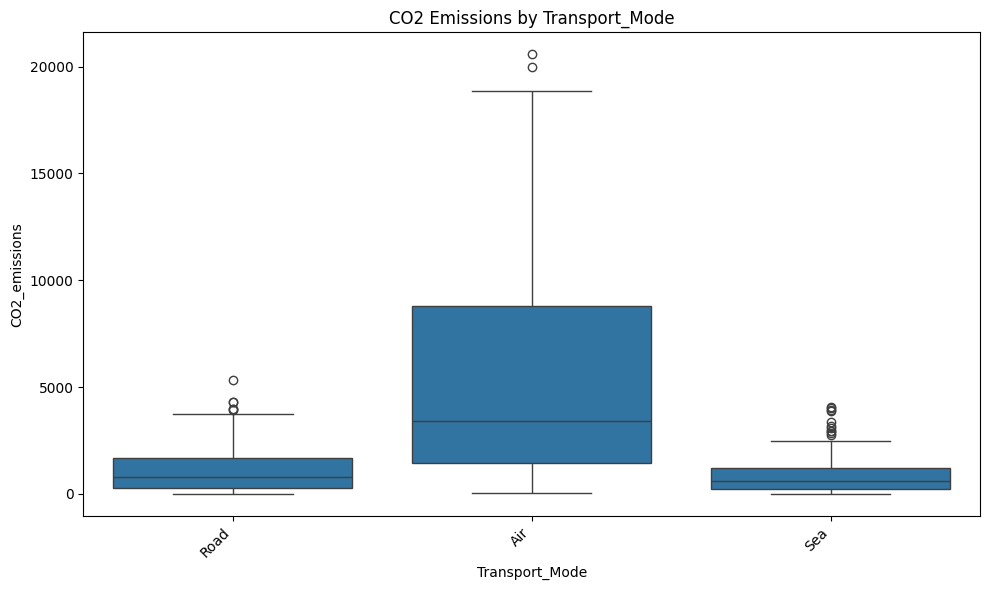

In [32]:
# --- Categorical Feature vs. Target Variable ---
categorical_features = df.select_dtypes(include='object').columns

for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='CO2_emissions', data=df)
    plt.title(f"CO2 Emissions by {col}")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

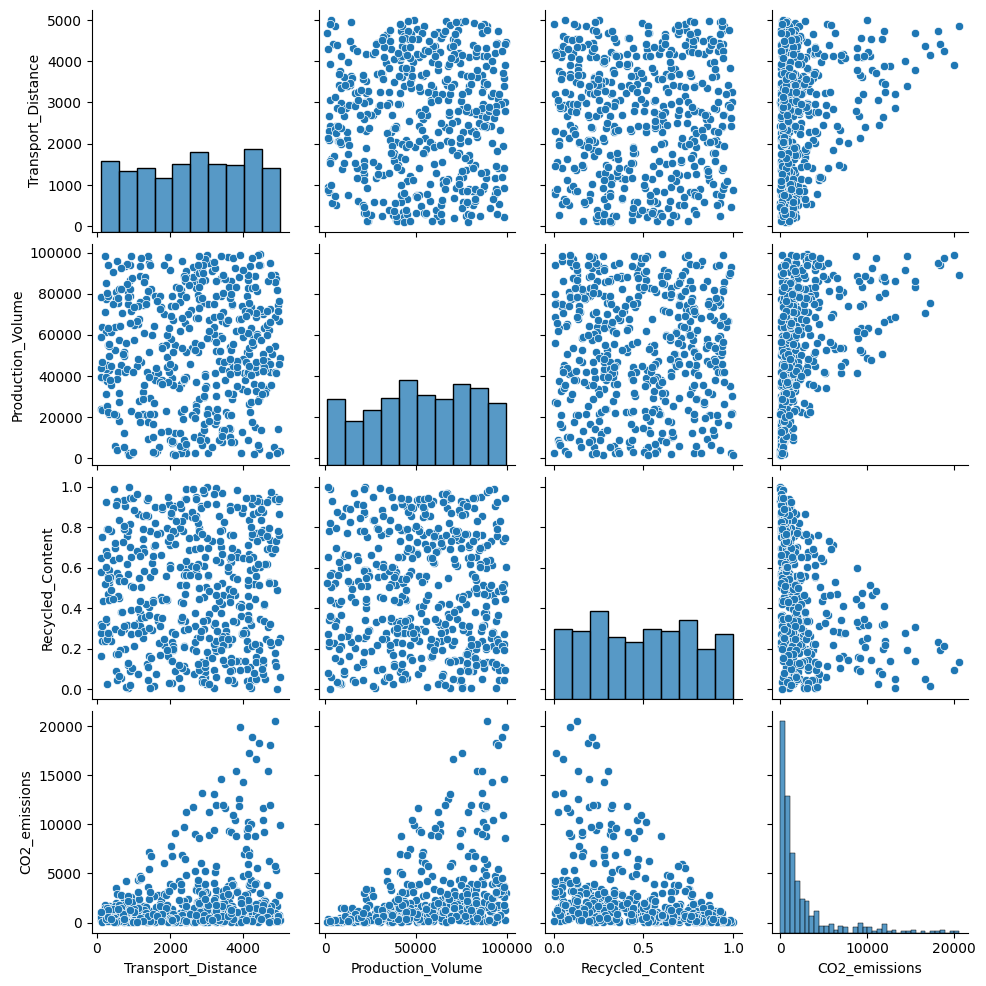

In [34]:
sns.pairplot(df[numerical_features])
plt.show()

#  Data Preprocessing

In [8]:
# Separate features and target variable
X = df.drop('CO2_emissions', axis=1)
y = df['CO2_emissions']

In [9]:
# Define categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

In [10]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Apply preprocessing to data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [13]:
print(X_train_processed[0:5,:])

[[ 0.          0.          0.          0.          0.          1.
   0.          1.          0.          0.          1.          0.
   0.          1.          0.          1.          0.          0.
   0.          1.          0.          0.          1.          0.
   0.          1.         -1.60766257 -0.59735987  1.02092717]
 [ 0.          0.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   1.          0.          0.          1.          0.          0.
   1.          0.          0.          1.          0.          0.
   1.          0.         -0.6475734   0.98202222 -0.61796028]
 [ 0.          0.          0.          0.          0.          1.
   0.          1.          0.          1.          0.          0.
   0.          1.          0.          1.          0.          0.
   1.          0.          1.          0.          0.          0.
   1.          0.         -0.1417556   1.23871681  1.27484343]
 [ 1.          0.  

# Model Training and Evaluation

In [14]:
# --- Model Training ---

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

# Model Evaluation


In [15]:
# --- Model Evaluation ---

# Make predictions on the test set
y_pred = model.predict(X_test_processed)

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 875496.56
R-squared: 0.95


In [17]:
# --- Feature Importance Analysis ---
importances = model.feature_importances_

In [18]:
# Get the names of features after preprocessing
feature_names = preprocessor.get_feature_names_out()

In [19]:
# Convert to a dataframe for easier handling
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

In [20]:
# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                             feature  importance
23           cat__Transport_Mode_Air    0.323119
28             num__Recycled_Content    0.255756
27            num__Production_Volume    0.228515
26           num__Transport_Distance    0.160224
2            cat__Material_Polyester    0.003273
3      cat__Material_Recycled Cotton    0.002903
15               cat__Dyeing_Natural    0.002630
20          cat__Energy_Fossil Fuels    0.001897
16       cat__Dyeing_Solution Dyeing    0.001804
17           cat__Finishing_Chemical    0.001802
0               cat__Material_Cotton    0.001592
21                 cat__Energy_Mixed    0.001545
13                cat__Weaving_Woven    0.001428
14          cat__Dyeing_Conventional    0.001242
4   cat__Material_Recycled Polyester    0.001236
11           cat__Spinning_Ring-Spun    0.001213
18         cat__Finishing_Mechanical    0.001186
8               cat__Source_Recycled    0.001154
6           cat__Source_Conventional    0.00110

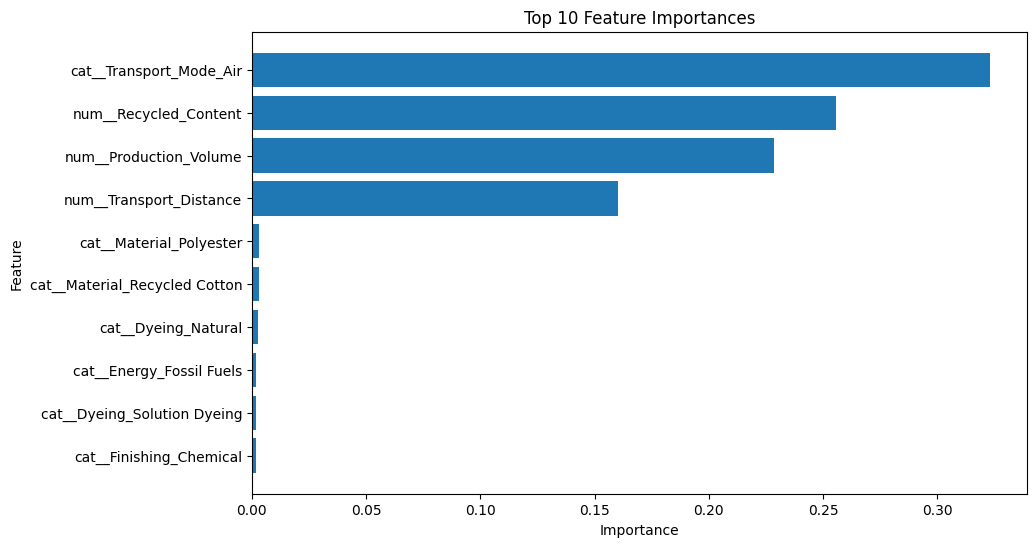

In [22]:
# Plot the top 10 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()